Saco promedio diario mensual (promedio de cada dia cada mes)

Hago un  ranking de las radiaciones. Para saca ENFICC


3.Tengo dos series de datos y sale 1.


El calculo de la efectividad del método sería ideal hacerlo para diferenmtes años y difrentes periodos (3, 6 y 12 meses)


In [3]:
import os
import pandas as pd
import statistics as st
import matplotlib.pyplot as plt
import scipy.stats as scp
import numpy as np

In [41]:
## Funciones

def ghi_mensual(serie_horaria):
    agnos = sorted(serie_horaria['AÑO'].unique())
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "DIAS", "GHImes"])
    for agno in agnos:
        for mes in range(1,13):
            nombre_energia = list(serie_horaria)[-1]
            dias = sorted(serie_horaria[(serie_horaria['AÑO'] == agno) &
                        (serie_horaria['MES'] == mes)]["DIA"].unique())
            ghi_mes = serie_horaria.loc[((serie_horaria["AÑO"] == agno)
                            & (serie_horaria["MES"] == mes)),
                                        nombre_energia].sum()/1000
            ghi_dict = {"AÑO":agno, "MES":mes, "DIAS":dias[-1],
                        "GHImes":ghi_mes}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
    return ghi_df

def ghi_dia(serie_ghi_mensual):
    agnos = sorted(serie_ghi_mensual['AÑO'].unique())
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "GHIdiario"])
    for agno in agnos:
        for mes in range(1,13):
            dias = serie_ghi_mensual.loc[((serie_ghi_mensual["AÑO"] == agno)
                            & (serie_ghi_mensual["MES"] == mes))
                                         ,"DIAS"].item()
            ghi_diario = serie_ghi_mensual.loc[(
                (serie_ghi_mensual["AÑO"] == agno)
                            & (serie_ghi_mensual["MES"] == mes)),
                "GHImes"].item()/dias
            ghi_dict = {"AÑO":agno, "MES":mes, "GHIdiario":ghi_diario}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
    return ghi_df

def extraer_datos(fuente, ciudad,agno_in):
    base_dir = os.path.join( '.',os.path.join( '02_taller01','data')) 
    output_dir = os.path.join( '.','output')
    serie_csv = os.path.join(base_dir,ciudad,fuente+'.csv')
    serie_pd = pd.read_csv(serie_csv, sep = ';',
                encoding='latin-1')
    serie_pd = serie_pd.sort_values(['AÑO','MES','DIA','HORA'])
    
    if agno_in != 0:
        serie_pd =  serie_pd[(serie_pd.AÑO)>=agno_in]
    
    return serie_pd

def enficc(datos):
    ghi_mensual_loc = ghi_mensual(datos)
    ghi_diario_loc = ghi_dia(ghi_mensual_loc)
    enficc = ghi_diario_loc.quantile(q=0.1, 
                                 numeric_only=True)["GHIdiario"]
    return enficc
    
def ajustar_datos(corta, NREL, nrel_truncada):
    """Corta en array y larga en df"""
    
    larga= NREL.NREL
    sigma_corta = st.stdev(corta)
    sigma_larga = st.stdev(nrel_truncada)
    prom_corta = st.mean(corta)
    prom_larga = st.mean(nrel_truncada)
    ajustada = (prom_corta-(sigma_corta/sigma_larga)*prom_larga)+(sigma_corta/sigma_larga)*larga
    d = {"AÑO":NREL.AÑO, "MES":NREL.MES, "DIA":NREL.DIA, "HORA":NREL.HORA,"IDEAM":ajustada}
    datos = pd.DataFrame(data=d)
    datos=datos[["AÑO","MES", "DIA", "HORA","IDEAM"]]
    
    
    
    return datos

def grafica_norma(ideam,nrel,ajst,nombre):
    """Entran los df en resolución horaria de las radiciaciones para IDEAM, NREL y Ajustada, respectivamente """
    
    output_dir = os.path.join( '.')
    
    y_IDEAM= sorted(ghi_dia(ghi_mensual(ideam)).GHIdiario)
    y_min = y_IDEAM[0]
    y_IDEAM = y_IDEAM/y_min
    y_NREL= sorted(ghi_dia(ghi_mensual(nrel)).GHIdiario)/y_min
    y_AJST= sorted(ghi_dia(ghi_mensual(ajst)).GHIdiario)/y_min
    x_1 = range(len(y_IDEAM))
    x_2 = range(len(y_NREL))
    plt.xlabel("Datos")
    plt.ylabel("Energía/Energía Base IDEAM")
    plt.plot(x_1,y_IDEAM,label = "IDEAM")
    plt.plot(x_2,y_NREL, label = "NREL")
    plt.plot(x_2,y_AJST, label="Ajustada")
    plt.legend(loc='upper left')
    plt.savefig(os.path.join(output_dir,nombre+'.png'), dpi=600)
    plt.show()
    
def error_enficc(ref,comp):
    e_1 = enficc(ref)
    e_2 = enficc(comp)
    error = abs(e_1-e_2)/e_1 *100
    
    return error

def rmsen(ref,comp):
    r = np.array(ref)
    c = np.array(comp)
    rmsd = np.sqrt(sum((c-r)**2)/len(r))
    ans = rmsd/(max(c)-min(c))
    
    return ans

def mbe(ref,comp):
    r = np.array(ref)
    c = np.array(comp)
    
    ans= sum(r-c)/sum(c)
    
    return ans
    
    
def errores(ref,comp):
    """El primero es el valor de referencia y el segundo el que se quiere evaluar"""
    
    ref_GHI= ghi_dia(ghi_mensual(ref)).sort_values(['AÑO','MES']).GHIdiario
    comp_GHI= ghi_dia(ghi_mensual(comp)).sort_values(['AÑO','MES']).GHIdiario
    error_1 = error_enficc(ref,comp)
    error_2 = rmsen(ref_GHI,comp_GHI)
    error_3 = mbe(ref_GHI,comp_GHI)
    ks_pvalue = scp.ks_2samp(ref_GHI,comp_GHI).pvalue
    
    print('\paragraph {El error en el calculo de la ENFICC es: ' , error_1, "\%}")
    print('\paragraph {El error NRMSE es: ' , error_2,"}")
    print('\paragraph {El error MBE es: ' , error_3,"}")
    print("\paragraph {El p-value de KS para las 2 series de datos es: ",ks_pvalue,"}")
    
def recortar(datos,agno_in,agno_fin,mes_in,mes_fin):
    if agno_in<min(datos.AÑO):
        print("Elige un año inicial mayor")
    
    if agno_fin>max(datos.AÑO):
        print("Elige un año final menor")
        
    if agno_fin<agno_in or mes_fin<mes_in:
        print("La escogencia de años o meses es errada")
    
    else:
        if agno_in == agno_fin:
            ans = datos[(datos.AÑO == agno_in) & (datos.MES >= mes_in) & (datos.MES <= mes_fin)]
            return ans
    
        else:
            ans = datos[(datos.AÑO >= agno_in) & (datos.AÑO <= agno_fin)]
            return ans

In [42]:
dic = ["Cali","Barranquilla","Carmendebolivar","Medellin","SantaMarta","Sucre","Uribia", "Valledupar"]
rdom = np.random.randint(0,high= len(dic)-1)
ciudad = dic[-1]
IDEAM_ciudad = extraer_datos('IDEAM',ciudad,0)
NREL_ciudad = extraer_datos('NREL',ciudad,min(IDEAM_ciudad.AÑO))

In [43]:
IDEAM = recortar(IDEAM_ciudad,2010,2010,1,12)
IDEAM = IDEAM.IDEAM
NREL = NREL_ciudad
ajst = ajustar_datos(IDEAM,NREL,recortar(NREL,2010,2010,1,12).NREL)

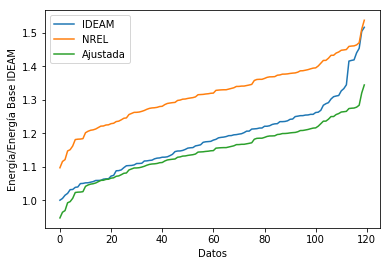

In [44]:
grafica_norma(IDEAM_ciudad,NREL_ciudad,ajst,ciudad)

In [39]:
print("Original")
errores(IDEAM_ciudad,NREL_ciudad)
print("Ajustada")
errores(IDEAM_ciudad,ajst)

Original
\paragraph {El error en el calculo de la ENFICC es:  14.7106265856 \%}
\paragraph {El error NRMSE es:  0.361863879712 }
\paragraph {El error MBE es:  -0.103215126141 }
\paragraph {El p-value de KS para las 2 series de datos es:  7.65209046374e-20 }
Ajustada
\paragraph {El error en el calculo de la ENFICC es:  4.73576319011 \%}
\paragraph {El error NRMSE es:  0.301003248202 }
\paragraph {El error MBE es:  0.0751731222951 }
\paragraph {El p-value de KS para las 2 series de datos es:  2.37310038076e-08 }


In [9]:
a="Casa"
a+ "mierda"

'Casamierda'